# Logistische Regression - GonzaloA

In [2]:
import pandas as pd
import numpy as np

# Train/validation split
from sklearn.model_selection import train_test_split

# Text feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Classifier and evaluation metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Pipeline utilities
from sklearn.pipeline import Pipeline

In [14]:
# Load each split from local CSVs
# Adjust the paths if needed
train_path = "../../data/GonzaloA - fake_news/train.csv"
val_path   = "../../data/GonzaloA - fake_news/evaluation.csv"
test_path  = "../../data/GonzaloA - fake_news/test.csv"

# Load this, if you want data without "(Reuters)"
#train_path = "../../data/GonzaloA - fake_news/train_without_reuters.csv"
#val_path   = "../../data/GonzaloA - fake_news/evaluation_without_reuters.csv"
#test_path  = "../../data/GonzaloA - fake_news/test_without_reuters.csv"

# Read with semicolon separator
df_train = pd.read_csv(train_path, sep=';')
df_val   = pd.read_csv(val_path,   sep=';')
df_test  = pd.read_csv(test_path,  sep=';')

# Quick sanity-check
print("Train shape:", df_train.shape)
print("Validation shape:", df_val.shape)
print("Test shape:", df_test.shape)

Train shape: (24353, 4)
Validation shape: (8117, 4)
Test shape: (8117, 4)


In [15]:
# form and shape
print("Train shape:", df_train.shape)
print("Validation shape:", df_val.shape)
print("Test shape:", df_test.shape)
print()
print("Train columns:", df_train.columns.tolist())

# first 5 rows of dataset
print(df_train.head(5))

Train shape: (24353, 4)
Validation shape: (8117, 4)
Test shape: (8117, 4)

Train columns: ['Unnamed: 0', 'title', 'text', 'label']
   Unnamed: 0                                              title  \
0           0  Palestinians switch off Christmas lights in Be...   
1           1  China says Trump call with Taiwan president wo...   
2           2   FAIL! The Trump Organization’s Credit Score W...   
3           3  Zimbabwe military chief's China trip was norma...   
4           4  THE MOST UNCOURAGEOUS PRESIDENT EVER Receives ...   

                                                text  label  
0  RAMALLAH, West Bank (Reuters) - Palestinians s...      1  
1  BEIJING (Reuters) - U.S. President-elect Donal...      1  
2  While the controversy over Trump s personal ta...      0  
3  BEIJING (Reuters) - A trip to Beijing last wee...      1  
4  There has never been a more UNCOURAGEOUS perso...      0  


In [16]:
# Merge text fields
def merge_text(row):
    return f"{row['title']} \n{row['text']}"

for df in [df_train, df_val, df_test]:
    df['input_text'] = df.apply(merge_text, axis=1)

# Define X and y
X_train, y_train = df_train['input_text'], df_train['label']
X_val,   y_val   = df_val['input_text'],   df_val['label']
X_test,  y_test  = df_test['input_text'],  df_test['label']  # y_test only for evaluation

In [17]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=20_000,    # Keep only the top 20,000 most frequent terms to limit dimensionality
    ngram_range=(1,2),      # Include both unigrams (single words) and bigrams (pairs of words)
    stop_words='english'    # Remove common English stop words (e.g., 'the', 'and')
)

# Fit the vectorizer on the training data and transform texts to sparse matrices
# fit_transform learns the vocabulary from X_train and then transforms X_train
X_train_tfidf = vectorizer.fit_transform(X_train)

# Use the already-fit vectorizer to transform validation and test sets
# transform uses the learned vocabulary to convert new texts into vectors
X_val_tfidf   = vectorizer.transform(X_val)
X_test_tfidf  = vectorizer.transform(X_test)

In [18]:
pipeline = Pipeline([
    ('tfidf', vectorizer),
    ('clf', LogisticRegression(max_iter=1000))
])

# Train
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=20000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf', LogisticRegression(max_iter=1000))])

In [21]:
# Predict
val_preds = pipeline.predict(X_val)

# Metrics
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print(classification_report(y_val, val_preds, target_names=['Real','Fake']))
print("Confusion Matrix:\n", confusion_matrix(y_val, val_preds))

Validation Accuracy: 0.9692004435136135
              precision    recall  f1-score   support

        Real       0.97      0.97      0.97      3803
        Fake       0.97      0.97      0.97      4314

    accuracy                           0.97      8117
   macro avg       0.97      0.97      0.97      8117
weighted avg       0.97      0.97      0.97      8117

Confusion Matrix:
 [[3675  128]
 [ 122 4192]]


In [22]:
# Generate predictions on the test set using our trained pipeline
# `test_preds` will be an array of predicted labels: 0 = real, 1 = fake
test_preds = pipeline.predict(X_test)a

# If the true labels for the test split (`y_test`) are available, evaluate performance:
# Print overall accuracy to see the fraction of correct predictions
print("Test Accuracy:", accuracy_score(y_test, test_preds))

# Print a detailed classification report (precision, recall, F1-score) for each class
print(classification_report(
    y_test,             # True labels
    test_preds,         # Predicted labels
    target_names=['Real','Fake']
))

Test Accuracy: 0.9724035973881976
              precision    recall  f1-score   support

        Real       0.97      0.97      0.97      3753
        Fake       0.97      0.98      0.97      4364

    accuracy                           0.97      8117
   macro avg       0.97      0.97      0.97      8117
weighted avg       0.97      0.97      0.97      8117



In [24]:
# Create a DataFrame pairing each test article with its predicted label
submission = pd.DataFrame({
    'text': df_test['text'],            # Raw text from the test set
    'predicted_label': test_preds       # Model output: 0 = real, 1 = fake
})
# Export the predictions to CSV for review or submission (no index column)
submission.to_csv('fake_news_predictions.csv', index=False)

In [25]:
# Create a DataFrame pairing each test article with its predicted label
submission = pd.DataFrame({
    'text': df_test['text'],            # Raw text from the test set
    'predicted_label': test_preds       # Model output: 0 = real, 1 = fake
})
# Export the predictions to CSV for review or submission (no index column)
submission.to_csv('fake_news_predictions.csv', index=False)

# ---
# Create a DataFrame pairing each test article with its true and predicted labels
misclassified = pd.DataFrame({
    'text': df_test['text'],        # Raw text from the test set
    'true_label': y_test,           # True labels: 0 = real, 1 = fake
    'predicted_label': test_preds   # Predicted labels from the model
})
# Filter only the misclassified examples
misclassified = misclassified[misclassified['true_label'] != misclassified['predicted_label']]

# Save these misclassified samples to a separate CSV
misclassified.to_csv('misclassified_samples.csv', index=False)

# Print the first 5 misclassified samples directly
print("Misclassified samples:")
print(misclassified.head(5))

Misclassified samples:
                                                 text  true_label  \
0   NEW YORK (Reuters) - Veteran actor and frequen...           1   
22  Is this common sense law even practical given ...           0   
39  the psychopathic and insincere jihad islams na...           1   
69  vaccines killers is what they are logged revan...           1   
77  (Reuters) - Melania Trump rose to her husband’...           1   

    predicted_label  
0                 0  
22                1  
39                0  
69                0  
77                0  


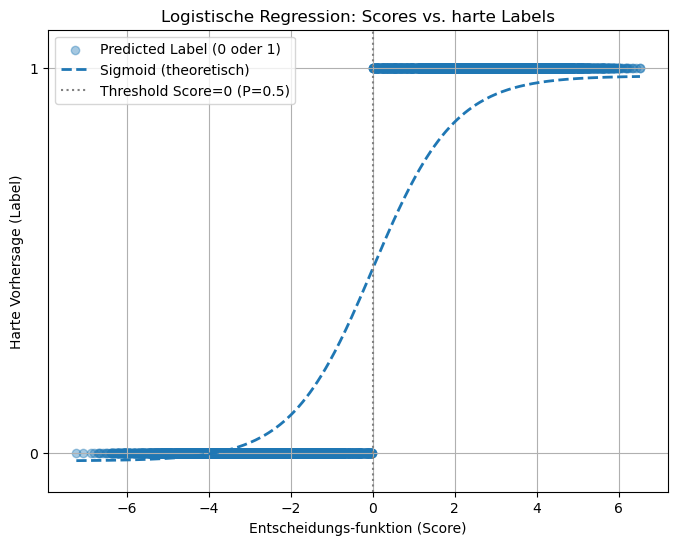

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Entscheidungsscores und harte Vorhersagen für die Validierungsdaten
dec_scores  = pipeline.decision_function(X_val)   # Roh-Score (logits)
pred_labels = pipeline.predict(X_val)             # harte Labels: 0 oder 1

plt.figure(figsize=(8, 6))

# Punkte: Score vs. hartes Label
plt.scatter(dec_scores, pred_labels, alpha=0.4, label='Predicted Label (0 oder 1)')

# Ideale Sigmoid-Kurve (zur Orientierung leicht angesenkt)
x = np.linspace(dec_scores.min(), dec_scores.max(), 300)
sigmoid = 1 / (1 + np.exp(-x))
# Wir verschieben die Kurve um –0.02, damit sie nicht genau auf den Punkten liegt
plt.plot(x, sigmoid - 0.02, linestyle='--', linewidth=2, label='Sigmoid (theoretisch)')

# Threshold-Linie bei Score = 0 (entspricht P=0.5)
plt.axvline(0, color='gray', linestyle=':', label='Threshold Score=0 (P=0.5)')

plt.yticks([0, 1])
plt.ylim(-0.1, 1.1)
plt.xlabel('Entscheidungs­funktion (Score)')
plt.ylabel('Harte Vorhersage (Label)')
plt.title('Logistische Regression: Scores vs. harte Labels')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()
